# Supervised Learning Model for Predicting Text Difficulty

Author: Yanying Jiang

The purpose of this part is to build a supervised learning classification model where we will be able to predict whether each document(sentence) in the dataset extracted from Wikipedia needs to be simplified.In the end, we hope to find a "best" model for predicting the text difficulty. The two classes are defined as following: 

Class 0: the sentence does NOT need to be simplified (Not Difficult).

Class 1: the sentence DOES need to be simplified (Difficult).

For supervised learning, we have explored four different types of algorithms. The feature representations are the same for the four models. It’s the feature representation extracted from Word2Vec using Bag of Words. 


## Import Packages and Load the Data

In [62]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score,confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [63]:
X_train = np.load('work/X_train.npy', allow_pickle=True)
y_train = np.load('work/y_train.npy', allow_pickle=True)
X_test = np.load('work/X_test.npy', allow_pickle=True)
y_test = np.load('work/y_test.npy', allow_pickle=True)

In [64]:
X_train.shape
X_train

array([[ 4.50352978e-02,  6.00388991e-01, -3.95767326e-02, ...,
         5.38313106e-01, -5.25885933e-02,  3.00000000e+00],
       [ 1.23106157e-01, -1.86731901e-01,  3.06317477e-01, ...,
         4.24844958e-02, -5.26645007e-02,  1.80000000e+01],
       [-1.73756810e-01,  3.81529705e-02,  9.34495208e-02, ...,
         1.58725339e-01,  3.09349138e-01,  1.30000000e+01],
       ...,
       [ 3.90132142e-02,  2.12377778e-01,  3.40997981e-02, ...,
        -1.75926444e-01,  1.48650268e-01,  1.10000000e+01],
       [-1.22956923e-01,  4.37406536e-02, -1.77284148e-01, ...,
        -3.28268702e-01, -1.11432150e-01,  2.00000000e+00],
       [-1.52533755e-01,  6.47480585e-02, -1.44042729e-02, ...,
        -6.19487655e-02,  1.39388635e-01,  1.90000000e+01]])

## Logistic Regression
We used logistic regression as our baseline model to train. Logistic regression predicts the category label by learning the coefficients for each feature. The output is a probability score between 0 and 1 so if the score is greater than a certain threshold then the document is classified into 1, otherwise 0. Since it’s simple and easy to interpret for initial exploration we implemented it as a starting point.  
In the first iteration with default parameters, the accuracy score is poorly around 64%. However we meant to use it as a baseline for comparison purposes, so we didn’t go too much further exploring it. 


In [4]:
mean_wv_lr = LogisticRegression(solver='lbfgs', max_iter=3000) #max_iter default 100 
mean_wv_lr.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [5]:
pred_mean_wv_lr = mean_wv_lr.predict(X_test)
pred_mean_wv_lr

array([1, 0, 0, ..., 1, 1, 0])

In [6]:
print(classification_report(y_test, pred_mean_wv_lr,target_names = ["Not Difficult", "Difficult"]))

               precision    recall  f1-score   support

Not Difficult       0.63      0.66      0.65     41549
    Difficult       0.65      0.62      0.63     41805

     accuracy                           0.64     83354
    macro avg       0.64      0.64      0.64     83354
 weighted avg       0.64      0.64      0.64     83354



In [7]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mean_wv_lr,X_test,y_test,cv=5)
print(scores)
print("Mean",scores.mean())
print("Std",scores.std())

[0.63439506 0.63163577 0.63991362 0.63157579 0.63953209]
Mean 0.6354104676635305
Std 0.003667432863760274


In [58]:
# from sklearn.metrics import roc_auc_score
# print('roc_auc:',roc_auc_score(y_test, pred_mean_wv_lr))
# print('accuracy:',accuracy_score(y_test, pred_mean_wv_lr))

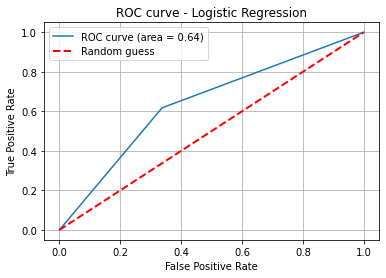

In [9]:
# Create ROC curve function 
def roc_curve_plot(y_test,y_pred,model_name):
    auc=roc_auc_score(y_test, y_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
    plt.title('ROC curve'+' - ' + model_name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, pred_mean_wv_lr,'Logistic Regression')

## Linear SVM Classifer
Linear SVM is widely considered as one of the best text classification algorithms. There are a few reasons that we choose Linear SVM:

1.Handles high-dimensional data very well. In text classification tasks, each n-gram/word can be represented as a feature vector, resulting in a high-dimensional matrix. SVM can work well in these scenarios. 

2.SVM is faster than many other algorithms, making it more efficient in real life. 

3.Linear SVC is scalable and robust to noise. Our text data may have a lot of noises that are not easy to identify. 

Parameter tuning was done on max_iter. A smaller number of iterations made Liblinear failed to 
converge. So we increased the max of iterations to 10000 that the model was able to converge. 


In [10]:
from sklearn.svm import LinearSVC
mean_wv_svm = LinearSVC(max_iter=10000,random_state =42)
mean_wv_svm.fit(X_train, y_train)

/Users/yanyingj/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=10000, random_state=42)

In [11]:
scores = cross_val_score(mean_wv_svm,X_test,y_test,cv=5)
print(scores)
print("Mean",scores.mean())
print("Std",scores.std())

/Users/yanyingj/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yanyingj/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yanyingj/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yanyingj/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.63391518 0.62869654 0.63943375 0.63049607 0.63857229]
Mean 0.6342227649485399
Std 0.004256634701216942


/Users/yanyingj/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
pred_mean_wv_svm = mean_wv_svm.predict(X_test)

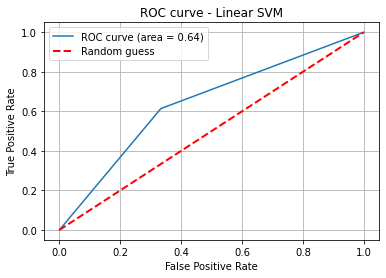

In [13]:
roc_curve_plot(y_test, pred_mean_wv_svm,'Linear SVM')

## Random Forest Classifier
Random is a popular algorithm based on decision trees and is part of the bagging model family. Random forest is prominent because of its high performance on various classification tasks, and it doesn’t require lots of standardization of features.  Our input data contains different types of features in different scales, making a random forest classifier potentially a good fit. 
Our initial iteration result actually proved this. With initial parameters of (n_estimators = 50, max_depth = 30) we got accuracy of 64%. 


In [14]:
mean_wv_rf = RandomForestClassifier(n_estimators = 50, max_depth = 30)
mean_wv_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=50)

In [15]:
pred_wv_rf = mean_wv_rf.predict(X_test)
# print(classification_report(y_test, pred_wv_rf,target_names = ["Not Difficult", "Difficult"]))

               precision    recall  f1-score   support

Not Difficult       0.67      0.62      0.65     41549
    Difficult       0.65      0.70      0.68     41805

     accuracy                           0.66     83354
    macro avg       0.66      0.66      0.66     83354
 weighted avg       0.66      0.66      0.66     83354



In [60]:
# print('accuracy:',accuracy_score(y_test, pred_wv_rf))

Explore results of the Random Forest Classifier using k-fold cross validation. Here we use k = 5

In [17]:
scores = cross_val_score(mean_wv_rf,X_test,y_test,cv=5)
print(scores)
print("Mean",scores.mean())
print("Std",scores.std())

[0.63625457 0.63517485 0.63505489 0.63979365 0.63455309]
Mean 0.6361662114221028
Std 0.001896636022609125


#### Random Forest Hyperparameter Tuning Using GridSearchCV
GridSearchCV was conducted for parameter tuning on max_depth and n_estimators( 'n_estimators': [5,20,50,100], 'max_depth': [2,10,20,30]), the best parameter turns out to be n_estimators = 100 and max_depth = 30, with accuracy score at 0.6629.

In [18]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,20,50,100],
    'max_depth': [2,10,20,30]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 10, 20],
                         'n_estimators': [5, 20, 50, 100]})

In [61]:
cv.best_params_

AttributeError: 'StratifiedShuffleSplit' object has no attribute 'best_params_'

In [20]:
#cv.best_estimator_
cv.best_score_

0.6629295778144564

In [ ]:
# cv.cv_results_

#### Create Random Forest Model with Best Parameters

In [72]:
rf_best = RandomForestClassifier(n_estimators = 100, max_depth = 30)

rf_best.fit(X_train,y_train)
rf_best_pred = rf_best.predict(X_test)


In [79]:
rf_best_scores = cross_val_score(rf_best,X_test,y_test,cv=5)
print(rf_best_scores)
print("Mean",rf_best_scores.mean())
print("Std",rf_best_scores.std())

[0.64333273 0.63877392 0.64261292 0.64723172 0.64181164]
Mean 0.6427525860672747
Std 0.0027252116722079767


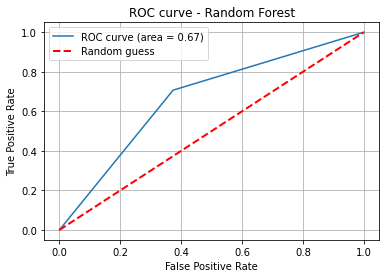

In [74]:
roc_curve_plot(y_test, rf_best_pred,'Random Forest')

## XGBoost (eXtreme Gradient Boosting)

To further explore decision-tree-based algorithms, we decided to try XGBoost, a type of ensemble model, which combines several weaker base learners to create a stronger and more accurate model. XGBoost uses gradient boosting to train decision trees iteratively, with each new tree correcting the errors made by the prior trees. 

XGBoost is widely adopted in industry and becoming more and more popular due to its good performance and scalability on high-dimensional datasets. However, it has a longer list of parameters so parameter tuning takes more time and computational effort. 


In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.8,
train_size=0.2, random_state=42)

#### Parameter Tuning for XGBoost
We conducted parameter tuning in two batches: the first time on gamma and learning rate ( 'gamma':[i/10.0 for i in range(0,5)],'learning_rate':[0.1,0.2,0.3]), the second time on max_depth and min_child_weight ('max_depth':[3,4,5,6], 'min_child_weight':[2,4,6]). The reason is that if we combine all parameters and tune all in one time, it will be 1200 fits in total and takes 60 hours approximately. But when we broke it down and used the best parameters from the first batch: gamma = 0.1 and learning rate = 0.1, we were able to reduce the training time to 3 hours, which was much more manageable.   

In [81]:
# Code for parameters inspired by https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
%%time
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_1 = {
 'gamma':[i/10.0 for i in range(0,5)],
 'learning_rate':[0.1,0.2,0.3]
}
gs_xgb1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=42), 
 param_grid = param_1, scoring=scoring,n_jobs=4, refit="AUC",cv=cv,verbose=2)
gs_xgb1.fit(X_train,y_train)


UsageError: Line magic function `%%time` not found.


In [43]:
gs_xgb1.best_params_, gs_xgb1.best_score_

({'gamma': 0.1, 'learning_rate': 0.1}, 0.7100570498494113)

In [57]:
# gs_xgb1.cv_results_

In [40]:
%%time
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_2 = {
 'max_depth':[3,4,5,6],
 'min_child_weight':[2,4,6]
}
gs_xgb2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=42), 
 param_grid = param_2, scoring=scoring,n_jobs=4, refit="AUC",cv=cv,verbose=2)
gs_xgb2.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................gamma=0.0, learning_rate=0.1; total time= 2.3min
[CV] END .......................gamma=0.0, learning_rate=0.1; total time= 2.3min
[CV] END .......................gamma=0.0, learning_rate=0.3; total time= 2.2min
[CV] END .......................gamma=0.1, learning_rate=0.1; total time= 2.2min
[CV] END .......................gamma=0.1, learning_rate=0.1; total time= 2.2min
[CV] END .......................gamma=0.1, learning_rate=0.2; total time= 2.2min
[CV] END .......................gamma=0.1, learning_rate=0.3; total time= 2.2min
[CV] END .......................gamma=0.2, learning_rate=0.1; total time= 2.2min
[CV] END .......................gamma=0.2, learning_rate=0.2; total time= 2.2min
[CV] END .......................gamma=0.2, learning_rate=0.2; total time= 2.2min
[CV] END .......................gamma=0.2, learning_rate=0.3; total time= 2.3min
[CV] END .......................gamma=0.3, learn

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.8,
            train_size=0.2),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_polic...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=N

In [46]:
gs_xgb2.best_params_, gs_xgb2.best_score_

({'max_depth': 6, 'min_child_weight': 2}, 0.7121347135934908)

In [69]:
# gs_xgb2.cv_results_

In [47]:
best_param = {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2}

#### Create XGB using Best Parameters

In [49]:
xgb = XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=6, gamma=0.1,
 min_child_weight=2,
 # colsample_bytree=0.8,
 # objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)


In [50]:
xgb.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [51]:
y_pred_xgb = xgb.predict(X_test)

In [52]:
scores = cross_val_score(xgb,X_test,y_test,cv=5)
print(scores)
print("Mean",scores.mean())
print("Std",scores.std())

[0.65029092 0.65047088 0.65029092 0.65832883 0.65236953]
Mean 0.6523502173777949
Std 0.003090551055459241


In [53]:
cm = confusion_matrix(y_test, y_pred_xgb)
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[26316 15233]
 [11849 29956]]


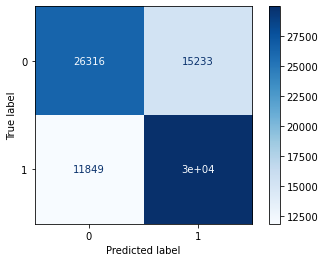

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

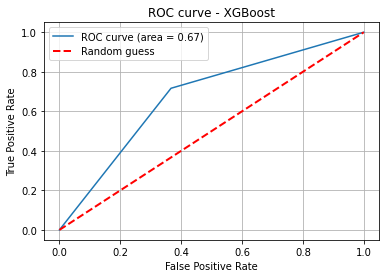

In [55]:
roc_curve_plot(y_test, y_pred_xgb,'XGBoost')

#### XGBoost with Best Params and Unsupervised Learning Derived Clusters

To further explore XGBoost algorithm and its sensitivity to feature representation, we added the predicted clusters from unsupervised learning model (K-Means with truncated SVD) to our word2vec exported features and trained it using the best parameters we obtained from parameter tuning. 


Note: Run the Unsupervised Learning Notebook first to obtain the X_train_plus and X_test_plus file.

In [75]:
X_train_plus = np.load('X_train_plus.npy', allow_pickle=True)
X_test_plus = np.load('X_test_plus.npy', allow_pickle=True)

In [76]:
xgb_unsup = XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=6, gamma=0.1,
 min_child_weight=2,
 nthread=4,
 scale_pos_weight=1,
 seed=42)

xgb_unsup.fit(X_train_plus,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [77]:
y_pred_xgb_unsup = xgb_unsup.predict(X_test_plus)

In [78]:
scores_unsup = cross_val_score(xgb_unsup,X_test_plus,y_test,cv=5)
print(scores_unsup)
print("Mean",scores_unsup.mean())
print("Std",scores_unsup.std())

[0.64741167 0.65053086 0.65185052 0.66120809 0.64925015]
Mean 0.6520502579347366
Std 0.004807730190218206


Unfortunately we don't see any improvement on our prediction, and we ended up with a higher standard deviation. The reason could be that the clusters generated from K-Means might be more relevant to other characteristics, for instance, topic, instead of readability. 

#### Trade-Offs
To balance training speed and accuracy, we made a tradeoff. During implementation, we created a copy of a subset of training data to speed up the training process. However, using the smaller dataset resulted in less accurate results compared to the full dataset. After implementation, we utilized the full dataset for training, but this method took a significant amount of time for both training and parameter tuning. Unfortunately, due to time constraints, we couldn't optimize all the parameters to achieve the highest possible accuracy, and there may be other parameter combinations that could lead to better results. In addition, our ability to explore other options is limited by computing power and training speed. While we would like to explore other language models like BERT, its higher computational requirements make it impractical for this particular task.

#### Reference:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/